# **LSTM MODEL**

In [1]:
#import librarries required for LSTM modeling
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
filename = "/content/bin.csv" #load CSV file
# from google.colab import files
# uploaded = files.upload()
# import io
# df = pd.read_csv(io.StringIO(uploaded['bin.csv'].decode('utf-8'))) # to read csv file from local directory
df = pd.read_csv(filename)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16801 entries, 0 to 16800
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              16801 non-null  object
 1   type            16801 non-null  object
 2   FillPercentage  16801 non-null  int64 
 3   Battery         16801 non-null  int64 
 4   eventDate       16801 non-null  object
 5   updateState     16801 non-null  bool  
 6   Distance        16801 non-null  int64 
dtypes: bool(1), int64(3), object(3)
memory usage: 804.1+ KB
None


In [3]:
df['eventDate'] = pd.to_datetime(df['eventDate']) #convert to datetime(time series'd)
df.set_axis(df['eventDate'], inplace=True) #making date as index
df.drop(columns=['id', 'type', 'Battery', 'updateState', 'Distance'], inplace=True) #drop columns not required for our modeling

In [4]:
df

,FillPercentage,eventDate
eventDate,,
2018-09-25,70,2018-09-25
2018-09-25,70,2018-09-25
2018-09-25,69,2018-09-25
2018-09-25,79,2018-09-25
2018-09-25,70,2018-09-25
...,...,...
2018-11-25,55,2018-11-25
2018-11-25,55,2018-11-25
2018-11-25,60,2018-11-25


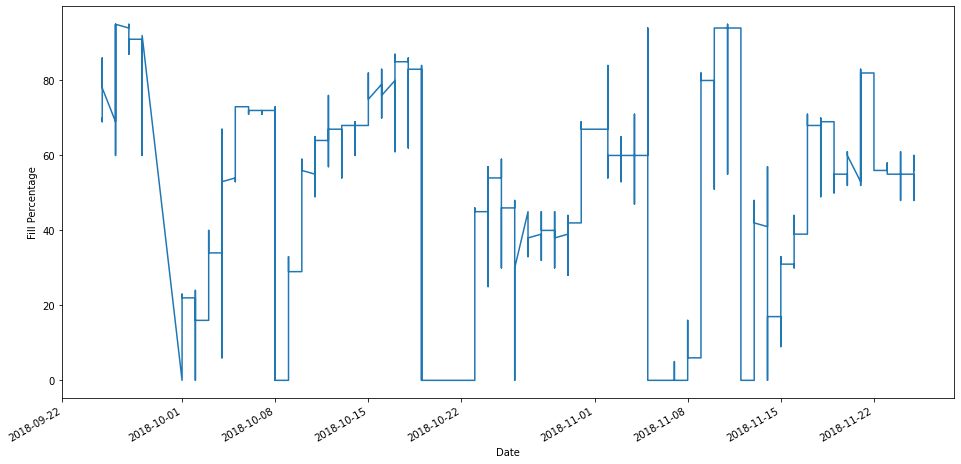

In [5]:
#Plot FillPercentage Values
plt.figure(figsize=(16,8))
df['FillPercentage'].plot()
plt.xlabel('Date')
plt.ylabel('Fill Percentage')
plt.show()

# Data Preprocessing

In [6]:
fill_data = df['FillPercentage'].values
fill_data = fill_data.reshape((-1,1))

split_percent = 0.80 #split data as 80% training set and 20% test set
split = int(split_percent*len(fill_data))

fill_train = fill_data[:split]
fill_test = fill_data[split:]

date_train = df['eventDate'][:split]
date_test = df['eventDate'][split:]

print(len(fill_train))
print(len(fill_test))

13440
3361


In [7]:
#converting the data from sequence to supervised data to train LSTM model

look_back = 15

train_generator = TimeseriesGenerator(fill_train, fill_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(fill_test, fill_test, length=look_back, batch_size=1)

# Model Implementation - (LSTM)

In [8]:
#import keras models and layers for LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse') #model compilation

num_epochs = 500
model.fit_generator(train_generator, epochs=num_epochs, verbose=1) #model training

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/500
672/672 [==============================] - 3s 5ms/step - loss: 459.7511
Epoch 2/500
672/672 [==============================] - 3s 5ms/step - loss: 38.5039
Epoch 3/500
672/672 [==============================] - 3s 5ms/step - loss: 129.3336
Epoch 4/500
672/672 [==============================] - 3s 5ms/step - loss: 35.7657
Epoch 5/500
672/672 [==============================] - 3s 5ms/step - loss: 23.6057
Epoch 6/500
672/672 [==============================] - 3s 5ms/step - loss: 21.3240
Epoch 7/500
672/672 [==============================] - 3s 5ms/step - loss: 20.9255
Epoch 8/500
672/672 [==============================] - 3s 5ms/step - loss: 42.3697
Epoch 9/500
672/672 [==============================] - 3s 5ms/step - loss: 39.1260
Epoch 10/500
672/672 [==============================] - 3s 5ms/step - loss: 38.9769
Epoch 11/500
672/672 [==============================] - 3s 5ms/step - loss: 38.7207
Epoch 1

In [9]:
import plotly.graph_objects as go #library for visualization

prediction = model.predict_generator(test_generator) #forecast/predict for test data

fill_train = fill_train.reshape((-1))
fill_test = fill_test.reshape((-1))
prediction = prediction.reshape((-1))

#Visualize Actual vs Predicted /Forecasted values
trace1 = go.Scatter(
    x = date_train,
    y = fill_train,
    mode = 'lines',
    name = 'Fill Percentage'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Forecasts'
)
trace3 = go.Scatter(
    x = date_test,
    y = fill_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Waste Fill Levels",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Fill Percentage"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()
plt.close()

Instructions for updating:
Please use Model.predict, which supports generators.


# Future Forecast

In [10]:
fill_data = fill_data.reshape((-1))

# Function to predict FillPercentage values for future dates
def predict(num_prediction, model):
    prediction_list = fill_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

# Function to generate future dates    
def predict_dates(num_prediction):
    last_date = df['eventDate'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30 #Forecast Future values for next 30 days i.e next one month.
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)


In [11]:
future_forecast = np.append(prediction,forecast)

In [12]:
# Plot values of future forecasted values
trace1 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Test Forecast'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode='lines',
    name = 'Future Forecast'
)
layout = go.Layout(
    title = "Waste Fill Levels",
    xaxis = {'title' : "eventDate"},
    yaxis = {'title' : "Fill Percentage"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()
plt.close()

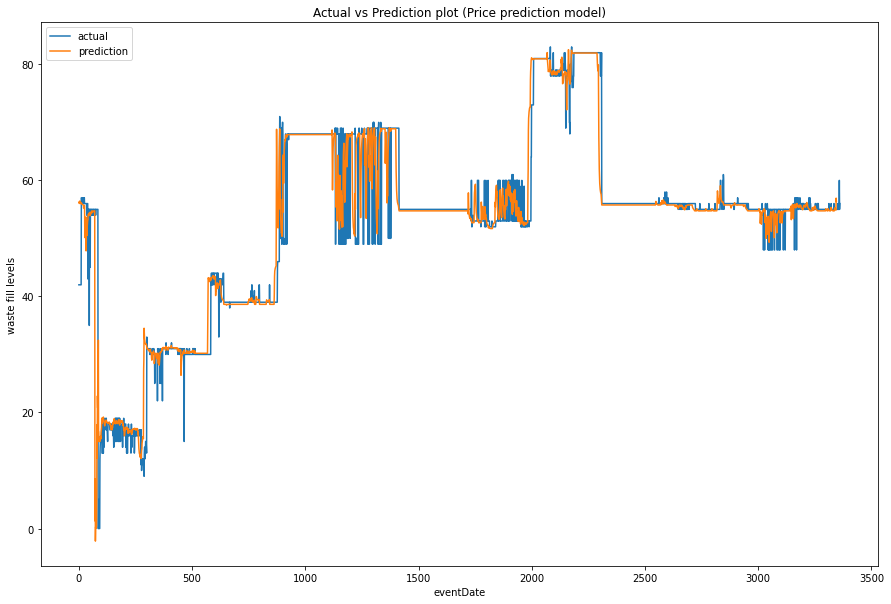

In [13]:
# Plot for Actual vs Forecasted Value
plt.figure(figsize = (15,10))
plt.plot(fill_test)
plt.plot(prediction)
plt.title('Actual vs Prediction plot')
plt.ylabel('waste fill levels')
plt.xlabel('eventDate')
plt.legend(['actual', 'prediction'], loc='upper left')
plt.show()

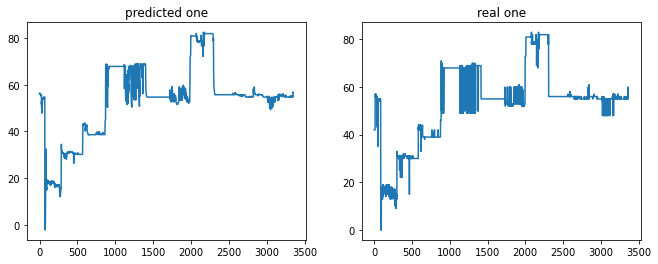

In [14]:
fig, ax = plt.subplots(1, 2,figsize=(11,4))
ax[0].set_title('predicted one')
ax[0].plot(prediction)
ax[1].set_title('real one')
ax[1].plot(fill_test)
plt.show()

# Model Evaluation

In [16]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [17]:
testD = create_dataset(fill_test, 15)

In [ ]:
# Evaluation metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr})

forecast_accuracy(testD[1], prediction)

{'corr': 0.9817121733561912,
 'mae': 1.2925003715621022,
 'mape': 0.03742320960830484,
 'me': -0.336418977885708,
 'mpe': -0.0014298838946333907,
 'rmse': 3.056053678508206}